## Dataset split

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

from __future__ import division

import brightside as bs
import numpy as np
import ntcir
import ntcir.IO as IO
import os
import os.path as osp
import re
import itertools
import pickle
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import collections
from easydict import EasyDict as edict
import pandas as pd

from skimage import io

In [3]:
users = IO.load_annotations(ntcir.filepaths)
categories = IO.load_categories(ntcir.filepaths)

### Bin packing the days

Using the First-Fit Decreasing algorithm for solving the bin packing of the days for splitting the dataset

In [4]:
import random

days = list()
for user in users:
    days.extend(user.days)
    
avg = np.sum([d.num_images for d in days])/len(days)
bs.print_attribute('Average number of images per day: ', avg)

<brightside.Attribute instance at 0x7f90e87187e8>

In [5]:
class Bin(object):
    """ Container for items that keeps a running sum """
    def __init__(self, item=None):
        self.items = list()
        self.sum_ = 0
        if item:
            self.append(item)

    def append(self, item):
        self.items.append(item)
        self.sum_ += item

def pack(values, maxValue):
    values = sorted(values, reverse=True)
    bins = list()

    for item in values:        
        for bin_ in bins:
            if bin_.sum_ + item <= maxValue:  
                bin_.append(item)
                break
        else:
            bins.append(Bin(item))
    return bins

random.seed(47)
bins = pack(days, 1000)
random.shuffle(bins)

Creating all combinations of m elements from n for set split

For the test set

$C_7\big(50\big)=\binom{50}{7}=\frac{50!}{7!\cdot43!}=99,884,400$

For the validation set

$C_3\big(43\big)=\binom{43}{3}=\frac{43!}{3!\cdot40!}=12,341$


In [6]:
import combinatorics as comb
import os.path

if not os.path.isfile('combinations_testset.txt'):
    comb.Twiddle(50, 7).generate_combinations('combinations_testset.txt')
    
if not os.path.isfile('combinations_valset.txt'):
    comb.Twiddle(43, 3).generate_combinations('combinations_valset.txt')

Mininum histogram distance function

In [7]:
import cv2
import re

def hist_min_distance(target_dist, histograms, comb_filepath, min_dist_filepath):
    min_dist = 2
    min_dist_ind = -1
    num_categories = target_dist.size
    min_dist_file=open(min_dist_filepath,'w',1)
    
    all_indices = np.arange(len(histograms))
    with open(comb_filepath) as infile:
        for i, line in enumerate(infile):
            comb_indices = np.asarray(map(int,line.split(' ')), dtype=int)
            left_indices = np.setdiff1d(all_indices, comb_indices)
            
            hist1 = np.zeros(num_categories,dtype=np.float32)    
            for ind in comb_indices:
                hist1 += histograms[ind]
                
            hist2 = np.zeros(num_categories,dtype=np.float32)    
            for ind in left_indices:
                hist2 += histograms[ind]

            dist1 = cv2.compareHist(target_dist, hist1, cv2.HISTCMP_BHATTACHARYYA)
            dist2 = cv2.compareHist(target_dist, hist2, cv2.HISTCMP_BHATTACHARYYA)            
            distance = dist1+dist2
            
            if distance < min_dist:
                min_dist_file.write("{}#{}#{}\n".format(i, distance, comb_indices))
                min_dist = distance
                min_dist_ind = i
    min_dist_file.close()
    
numbers = re.compile('\d+(?:\.\d+)?')
def get_closest_comb(min_dist_filepath):
    with open(min_dist_filepath) as min_dist_file:
        lines= [l for l in min_dist_file]
        comb_ind, dist, indices = lines[-1].split('#')
        indices = np.asarray(map(int,numbers.findall(indices)))
    return indices, dist, comb_ind

Calculating the histograms for all and each bin

In [8]:
num_categories = 21
histograms = list()
dataset_histogram = np.zeros(num_categories,dtype=np.float32)
for b in bins:
    histogram = np.zeros(num_categories,dtype=np.float32)
    for day in b.items:
        annotations = [image.label for image in day.images]
        histogram += np.bincount(annotations,minlength=num_categories)
    histograms.append(histogram)
    dataset_histogram += histogram
dataset_distribution = dataset_histogram / np.linalg.norm(dataset_histogram)

Splitting the dataset

In [9]:
min_dist_filepath = 'minimum_distance_testset.txt'
if not os.path.isfile(min_dist_filepath):
    hist_min_distance(dataset_distribution, histograms, 'combinations_testset.txt', min_dist_filepath)

test_indices, _, _ = get_closest_comb(min_dist_filepath)

all_indices = np.arange(len(bins))
left_indices = np.setdiff1d(all_indices, test_indices)
left_histograms = [histograms[i] for i in left_indices]

min_dist_filepath = 'minimum_distance_valset.txt'
if not os.path.isfile(min_dist_filepath):
    hist_min_distance(dataset_distribution, left_histograms, 'combinations_valset.txt', min_dist_filepath)

val_indices, _, _ = get_closest_comb(min_dist_filepath)
val_indices = left_indices[val_indices]

train_indices = np.setdiff1d(left_indices, val_indices)

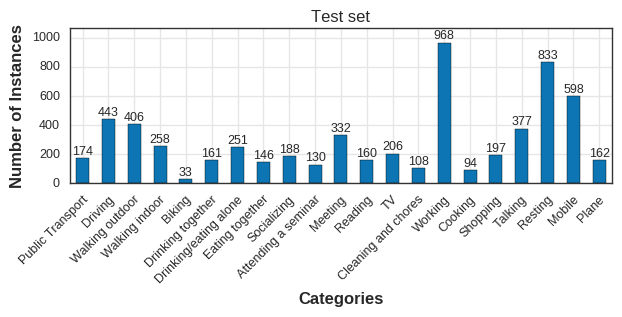

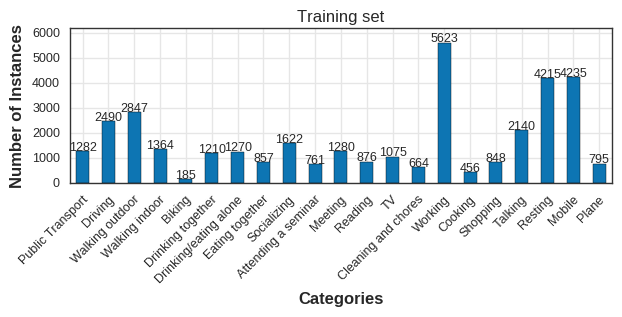

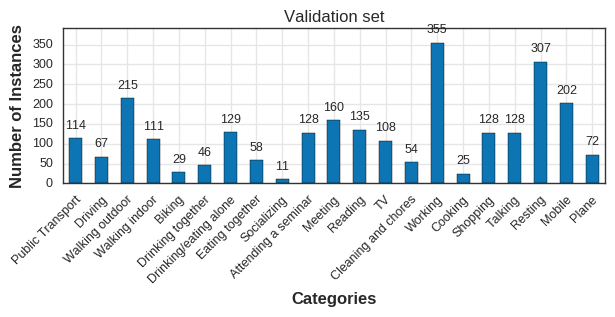

In [23]:
test_hist_sum = np.zeros(num_categories,dtype=np.float32)    
for ind in test_indices:
    test_hist_sum += histograms[ind]
test_histogram = pd.DataFrame(data=test_hist_sum, index=categories)
fig, ax = bs.plot_datasets_summary(test_histogram,figsize=(7,2),annot_rotation=45, axis_fontsize=9,title="Test set")

training_hist_sum = np.zeros(num_categories,dtype=np.float32)    
for ind in train_indices:
    training_hist_sum += histograms[ind]
training_histogram = pd.DataFrame(data=training_hist_sum, index=categories)            
fig, ax = bs.plot_datasets_summary(training_histogram,figsize=(7,2),annot_rotation=45, axis_fontsize=9,title="Training set")
plt.show()

validation_hist_sum = np.zeros(num_categories,dtype=np.float32)    
for ind in val_indices:
    validation_hist_sum += histograms[ind]
validation_histogram = pd.DataFrame(data=validation_hist_sum, index=categories)            
fig, ax = bs.plot_datasets_summary(validation_histogram,figsize=(7,2),annot_rotation=45, axis_fontsize=9,title="Validation set")
plt.show()

Creating split files

In [32]:
split_indices = [train_indices, val_indices, test_indices]
split_filepaths = ['training_split.txt','validation_split.txt', 'test_split.txt']
for indices, filepath in zip(split_indices, split_filepaths):    
    split_bins = [bins[i] for i in indices]
    
    split_file = open(filepath, "w")
    for b in split_bins:
        for day in b.items:
            print >>split_file, day.user.id_, day.date
    split_file.close()    